# Step 1: Import Libraries and Load the Dataset

In [26]:
# Imports

#pathlib: modern, clean way to handle file and folder paths
from pathlib import Path

#shutil: used to copy files from raw folders to the train and test folders
import shutil

import random

# nump useful for numerical operations
import numpy as np

import pandas as pd

#matplotlib.pyplot: uswed for visualizations
import matplotlib.pyplot as plt


import seaborn as sns

from PIL import Image

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_curve, average_precision_score

#tensorflow and keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import load_model




# Step 2: Data setup

In [21]:
# Here we first must define the original datasets paths
# then educe them to 5,000 images for train and 2,000 for test which will be appropriate for the scale of the workshop

raw_train_dir = Path("data/raw/train/train")
# raw_test_dir  = Path("data/raw/test/test")

#Paths for processsed/reduced dataset
train_dir = Path("data/train")
test_dir = Path("data/test")


#move iamges into subfolders for cat and dog

for folder in [train_dir /"cats", train_dir / "dogs",
               test_dir / "cats", test_dir / "dogs",]:
    folder.mkdir(parents=True, exist_ok=True)


#Randomly takes 2,5000 cats and dog images from the data set to for the reduced training dataset

def copy_random_n_images_by_prefix(src_folder, prefix, dest_folder, n):

    all_files = list(src_folder.glob(f"{prefix}*.jpg")) #list all images
    random.shuffle(all_files) #randomly  pick n
    selected = all_files[:n]
    for f in selected:
        shutil.copy(f, dest_folder /f.name)

#Copy the random 2,5000 per class for training (cats and dogs)
copy_random_n_images_by_prefix(src_folder=raw_train_dir, prefix="cat", dest_folder=train_dir / "cats", n=2500)
copy_random_n_images_by_prefix(src_folder=raw_train_dir, prefix="dog", dest_folder=train_dir / "dogs", n=2500)

#Since the training is labeled byt the test is not we get the reaming cats and dogs from the train set and then shuffle and pick test
test_cats = list(raw_train_dir.glob("cat*.jpg"))
test_dogs = list(raw_train_dir.glob("dog*.jpg"))

#shuffle
random.shuffle(test_cats)
random.shuffle(test_dogs)

for f in test_cats [2500:3500]:
    shutil.copy(f, test_dir /"cats"/f.name)

for f in test_dogs [2500:3500]:
    shutil.copy(f, test_dir /"dogs"/f.name)

#print result

print("REduced dataset created sucessfully")


REduced dataset created sucessfully


# Step 3: EDA

Training set: {'cats': 8464, 'dogs': 8364}
Test set: {'cats': 3551, 'dogs': 3553}


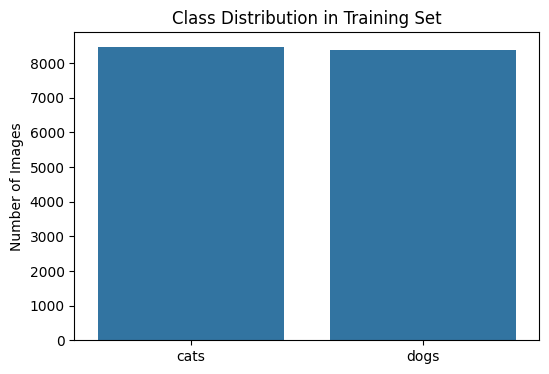

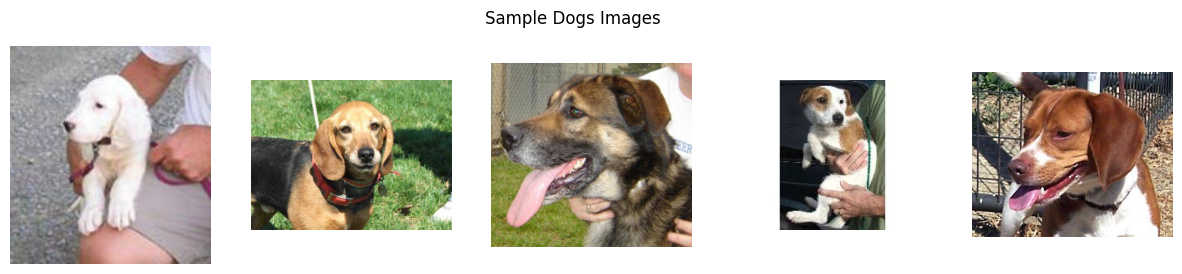

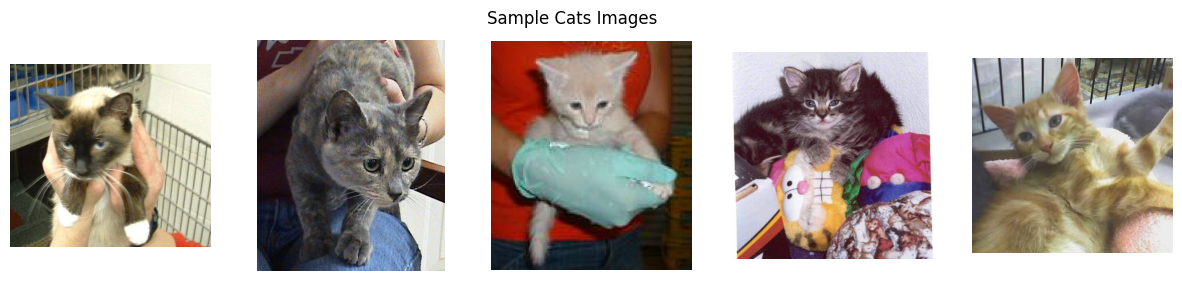

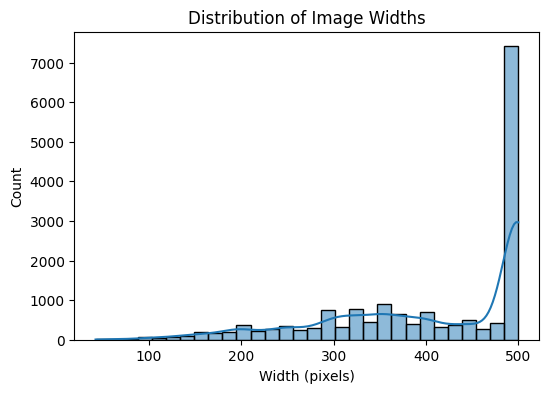

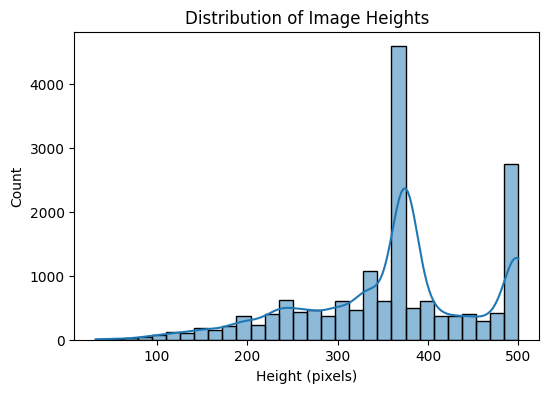

Image Width Stats
Mean: 404.24
Median: 447.00
Max: 500.00
Min: 42.00

Image Heights Stats
Mean: 361.10
Median: 374.00
Max: 500.00
Min: 32.00


In [22]:
# Count the amount of images are present per class

def count_images(directory):
    classes = ["cats", "dogs"]
    counts = {}
    for cls in classes:
        counts[cls] = len(list((directory / cls).glob("*.jpg")))
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set:", train_counts)
print("Test set:", test_counts)

# Visualize distribution of cats vs dogs

plt.figure(figsize=(6,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.show()

#Show Sample Images from each class

def show_samples(directory, class_name, n=5):
    files = list((directory / class_name).glob("*.jpg"))
    samples = random.sample(files, n)

    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(samples):
        img = Image.open(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Sample {class_name.capitalize()} Images")
    plt.show()

show_samples(train_dir, "dogs")
show_samples(test_dir, "cats")


#Analyze image sizes (width x height)
def get_image_sizes(directory):
    sizes = []
    for cls in ["cats", "dogs"]:
        for img_path in (directory / cls).glob("*.jpg"):
            img = Image.open(img_path)
            sizes.append(img.size)
    return np.array(sizes)
sizes = get_image_sizes(train_dir)
widths = sizes[:, 0]
heights = sizes[:, 1]


#Histogram of widths and heights
plt.figure(figsize=(6,4))
sns.histplot(widths, bins=30, kde=True)
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(heights, bins=30, kde=True)
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.show()


#Print staistics
print("Image Width Stats")
print(f"Mean: {np.mean(widths):.2f}")
print(f"Median: {np.median(widths):.2f}")
print(f"Max: {np.max(widths):.2f}")
print(f"Min: {np.min(widths):.2f}")

print("\nImage Heights Stats")
print(f"Mean: {np.mean(heights):.2f}")
print(f"Median: {np.median(heights):.2f}")
print(f"Max: {np.max(heights):.2f}")
print(f"Min: {np.min(heights):.2f}")

# Step 4: Define a Neural Network

In [23]:
# Image Dimensions

img_height = 150
img_width = 150
batch_size = 32

# Data generators for training and validation

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2 # this si 20% of training data used as validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    shuffle=True

)

#Define the model

custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') #binary classification
])

#Compile model

custom_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# CAllback to save the best model

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True
)

# Train the model

history_custom = custom_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint_cb]

)


Found 13464 images belonging to 2 classes.
Found 3364 images belonging to 2 classes.


C:\Users\jjbed\Downloads\PracticalLabCNN_3_JB-\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5700 - loss: 0.7964

421/421 ━━━━━━━━━━━━━━━━━━━━ 117s 272ms/step - accuracy: 0.6216 - loss: 0.6682 - val_accuracy: 0.7039 - val_loss: 0.5929
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7353 - loss: 0.5334

421/421 ━━━━━━━━━━━━━━━━━━━━ 133s 317ms/step - accuracy: 0.7369 - loss: 0.5275 - val_accuracy: 0.7512 - val_loss: 0.5169
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 119s 283ms/step - accuracy: 0.7958 - loss: 0.4390 - val_accuracy: 0.7476 - val_loss: 0.5203
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 111s 263ms/step - accuracy: 0.8420 - loss: 0.3572 - val_accuracy: 0.7693 - val_loss: 0.5422
Epoch 5/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 111s 265ms/step - accuracy: 0.8877 - loss: 0.2658 - val_accuracy: 0.7640 - val_loss: 0.5559
Epoch 6/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 113s 268ms/step - accuracy: 0.9316 - loss: 0.1739 - val_accuracy: 0.7640 - val_loss: 0.6587
Epoch 7/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 111s 264ms/step - accuracy: 0.9566 - loss: 0.1158 - val_accuracy: 0.7711 - val_loss: 0.7569
Epoch 8/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 111s 265ms/step - accuracy: 0.9690 - loss: 0.0876 - val_accuracy: 0.7699 - val_loss: 0.8051
Epoch 9/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 110s 261ms/step - accuracy: 0.9786 - loss: 0.06

## Traning Vs Validation Plot for Model

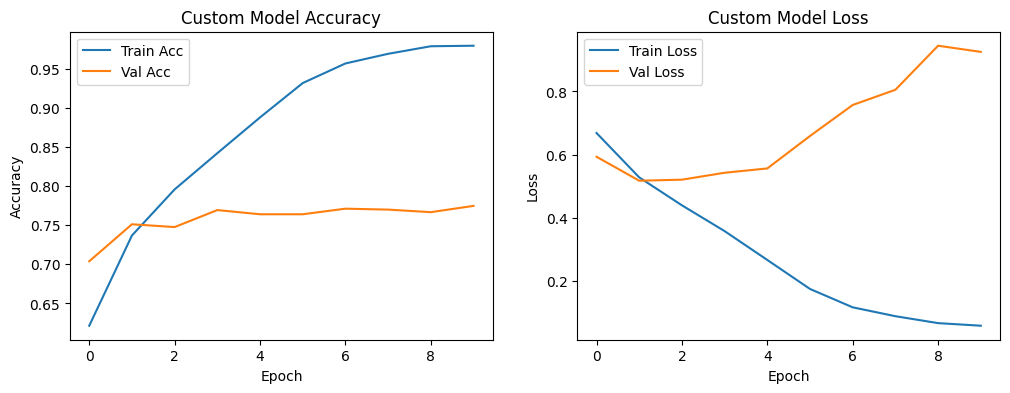

In [24]:
plt.figure(figsize=(12,4))


#Accuracy
plt.subplot(1,2,1)
plt.plot(history_custom.history['accuracy'], label='Train Acc')
plt.plot(history_custom.history['val_accuracy'], label='Val Acc')
plt.title('Custom Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_custom.history['loss'], label='Train Loss')
plt.plot(history_custom.history['val_loss'], label='Val Loss')
plt.title('Custom Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Step 5: Fine Tune VGG16 (Pre-Trained on imagenet

In [ ]:
# Load VGG16 without the top classifier layers

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

#Freeze base model layers to start
base_model.trainable= False

#Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs=base_model.input, outputs=predictions)

#Compile the modelk

vgg_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Callback to save the best model
checkpoint_cb_vgg = tf.keras.callbacks.ModelCheckpoint(
    "best_vgg_model.h5", save_best_only=True
)

#Train the model
history_vgg = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint_cb_vgg]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8197 - loss: 0.3845

421/421 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.8518 - loss: 0.3315 - val_accuracy: 0.8594 - val_loss: 0.3056
Epoch 2/10
253/421 ━━━━━━━━━━━━━━━━━━━━ 6:02 2s/step - accuracy: 0.8817 - loss: 0.2734

# Plot traning vs Validation for VGG16

In [ ]:
plt.figure(figsize=(12,4))

#Accuracy
plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'], label='Train Acc')
plt.plot(history_vgg.history['val_accuracy'], label='Val Acc')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Loss
plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Step 6: Explore the relative performance of the models

#### Load Best Saved Models

In [ ]:
# Load tthe best versions of models

#Load best custom model
best_custom_model = load_model("best_custom_model.h5")

#load best VGG16 model
best_vgg_model = load_model("best_vgg_model.h5")

In [ ]:
#### Prepare Test Data Generator

In [ ]:
# Test Data Generatyor

test_datagen = ImageDataGenerator(resacle=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1, # 1 iamage at a time
    class_mode="binary",
    shuffle=False # important to match predictions
)


# Get true labels
y_true = test_generator.classes
class_labels =  list(test_generator.class_indices.keys())

#### Evaluate Accuracy

In [ ]:
# Predictions
y_pred_model = (best_custom_model.predict(test_generator) > 0.5).astype("int32")
y_pred_vgg = (best_vgg_model.predict(test_generator) > 0.5).astype("int32")


#Accuracy

acc_model= accuracy_score(y_true, y_pred_model)
acc_vgg = accuracy_score(y_true, y_pred_vgg)

print(f"Custom Model Accuracy: {acc_model:.4f}")
print(f"VGG Model Accuracy: {acc_vgg:.4f}")


#### Confusion Matrix

In [ ]:
# Model

cm_custom = confusion_matrix(y_true, y_pred_model)
plt.figure(figsize=(5,4))
sns.heatmap(cm_custom, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Custom Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# VGG16 model

cm_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(5,4))
sns.heatmap(cm_vgg, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("VGG16 Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Precision, Recall & F1 Score

In [ ]:
#
print("Custom Model Classification Report:")
print(classification_report(y_true, y_pred_model, target_names=class_labels))

print("\n VGG16 Model Classification Report:")
print(classification_report(y_true, y_pred_vgg, target_names=class_labels))


Precision-Recall Curve

In [ ]:
# Custom model probabilities

y_prob_model = best_custom_model.predict(test_generator)
precision_m, recall_m, _ = precision_recall_curve(y_true, y_prob_model)
ap_c = average_precision_score(y_true, y_prob_model)

plt.figure(figsize=(6,5))
plt.plot(recall_m, precision_m, label=f'Custom Model (AP={ap_c:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

#VGG16 Proababilitlies
y_prob_vgg = best_vgg_model.predict(test_generator)
precision_v, recall_v, _ = precision_recall_curve(y_true, y_prob_vgg)
ap_v = average_precision_score(y_true, y_prob_vgg)

plt.figure(figsize=(6,5))
plt.plot(recall_v, precision_v, label=f'VGG16 Model (AP={ap_v:.2f})', color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()




#### Explore Misclassified Examples